<h1>Gradient Descent</h1>

In my notes on neural networks, I realized that I haven't given much justice to describing gradient descent. So, I decided to create a separate notebook where I describe gradient descent and its many variations.

<h2>Concept</h2>

The concept behind gradient descent is that given a convex functions (where the global minima are the local minima), we can find the minimum iteratively by computing the *gradient* of that function at specific points. Given a cost function, $J$, we can minimize it using the equation:

$$w \rightarrow w' = w - \eta \nabla_w J(w) $$

where $w$ is a column vector of weights and $x$ is a column vector of the input features. $\eta$ is a learning rate which is a hyperparameter that we adjust. Let's assume we have an equation of the form:

$$w_1x_1 + w_2x_2 + ... + w_n = w^Tx$$

(the last entry in the vector $x$ is 1). Then, given an appropriate cost function, we can find the vector $w$ such that $w^Tx = \hat{y} \approx y$. For now, we will define the cost function as the mean-squared error (MSE) function:

$$J(x) = \frac{1}{2n} \sum_{i=1}^n \parallel \hat{y}^i - y^i \parallel^2 = \frac{1}{2n} \sum_{i=1}^n \parallel w^Tx^i - y^i \parallel^2$$

where $n$ is the number of examples. The entries for the gradient of this function $\nabla_w J(x)$ is:

$$\frac{\partial J}{\partial w_j} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}^i - y^i)x^i_j$$

<h2>Example</h2>

In order to demonstrate gradient descent, let's create some sample data and then write the gradient descent algorithm. First, let's write the boilerplate to generate the sample data:


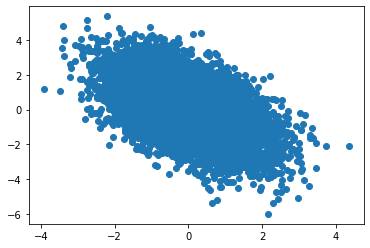

In [352]:
import time
import numpy as np
import matplotlib.pyplot as plt

def generate_rand_func(n: int, d: int):
    x = np.random.randn(n, d, 1)
    w = np.random.randn(d, 1)
    y = np.dot(w.T, x)
    y[0] += np.random.randn(n, 1)
    return (y.reshape(n, 1), x)

def cost(y, w, x):
    return sum([ np.linalg.norm((np.dot(w.T, x[i]) - y[i, 0]))**2 for i in range(0, x.shape[0]) ]) / (2*x.shape[0])

(y, x) = generate_rand_func(10000, 2)
plt.scatter(x[:, 0], y)

The above generates some data and then graphs it. As you can see, there's a linear correlation in the data. Note that in this case, I'm going to assume (for simplicity) that y is a scalar (or $1 \text{ x } 1$ vector). This doesn't change the implementation too much, but it makes things easier to think about. Now, we implement *batch gradient descent*, which operates on the entire dataset:

Took 12.260829872000613 seconds
J(x) = 0.5147469209461476


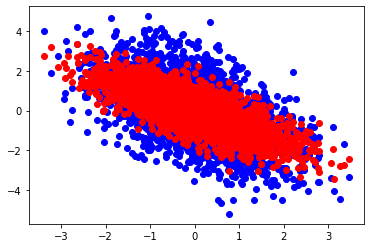

In [353]:
def gradient_descent(y, x, eta: float, niters: int):
    (n, d) = (x.shape[0], x.shape[1])
    w = np.random.randn(d, 1)
    for m in range(0, niters):
        nabla_J = np.zeros((d, 1), dtype=float)
        for j in range(0, nabla_J.shape[0]):
            s = 0.0
            for i in range(0, n):
                s += (np.dot(w.T, x[i]) - y[i, 0]) * x[i, j]
            nabla_J[j, 0] = s/n
        w = w - eta * nabla_J
    return w

def test_gradient_descent():
    split = int(0.7*x.shape[0])
    start = time.perf_counter()
    w = gradient_descent(y[:split], x[:split], 0.05, 100)
    end = time.perf_counter()
    plt.scatter(x[split:, 0], y[split:], c='b') # Test data: blue
    plt.scatter(x[split:, 0], [np.dot(w.T, x[i]) for i in range(split, x.shape[0])], c='r') # Predictions: red
    print('Took {} seconds'.format(end-start))
    print('J(x) = {}'.format(cost(y, w, x)))

test_gradient_descent()

Not bad! However, there is still a lot left to be desired
with this implementation. On my machine, the above took almost 20 seconds to run! We can vectorize the above implementation so that we don't have to use for loops. This will save us some time in the long run. Let's try that out.

Took 0.06802890800099703 seconds
J(x) = 0.5146680939973749


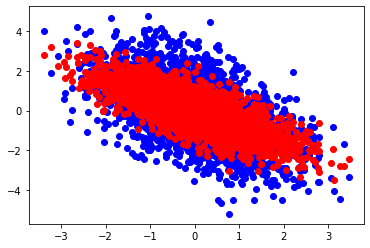

In [354]:
def gradient_descent(y, x, eta: float, niters: int):
    (n, d) = (x.shape[0], x.shape[1])
    w = np.random.randn(d, 1)
    for m in range(0, niters):
        w = w - eta * np.sum((w.T @ x - y.reshape(n, 1, 1)) * x, axis=0) / n
    return w

test_gradient_descent()

This is an order of magnitude better. But the algorithm can still be improved. We can actually reduced the parameters we give to the `gradient_descent` function. The `niters` parameter specifies the number of
steps to make. By treating this as a hyperparameter, we risk taking unnecessary steps. This is an easy fix. Let $\hat{w}_1$ be the predicted weight vector after the $k^{th}$ iteration and $\hat{w}_2$ be the predicted weight
vector after the $(k+1)^{th}$ iteration. Thus, we can say: 

$$\parallel \hat{w}_2 - \hat{w}_1 \parallel < \epsilon$$

where $\epsilon$ is a small positive real number that indicates the acceptable difference between $\hat{w}_2$ and $\hat{w}_1$. If the difference between the two is small enough, we can stop the algorithm
since further changes won't affect the difference. Let's rewrite the functions:


Took 0.07727842800159124 seconds
J(x) = 0.5145849205921198


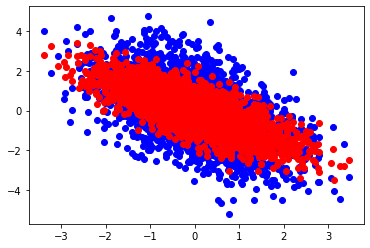

In [355]:
def gradient_descent(y, x, eta: float):
    (n, d) = (x.shape[0], x.shape[1])
    w = np.random.randn(d, 1)
    w_prev = None
    epsilon = 1e-5
    while True:
        if w_prev is not None and np.linalg.norm(w-w_prev) < epsilon:
            break
        w_prev = w
        w = w - eta * np.sum((w.T @ x - y.reshape(n, 1, 1)) * x, axis=0) / n
    return w

def test_gradient_descent(draw_scatter=True):
    split = int(0.7*x.shape[0])
    start = time.perf_counter()
    w = gradient_descent(y[:split], x[:split], 0.05) # No more niters
    end = time.perf_counter()
    if draw_scatter:
        plt.scatter(x[split:, 0], y[split:], c='b') # Test data: blue
        plt.scatter(x[split:, 0], [np.dot(w.T, x[i]) for i in range(split, x.shape[0])], c='r') # Predictions: red
    print('Took {} seconds'.format(end-start))
    print('J(x) = {}'.format(cost(y, w, x)))

test_gradient_descent()

Now we will look at some variations of gradient descent

<h2>Mini-Batch and Stochastic Gradient Descent</h2>

Up until now, we've tried gradient descent with a batch size of 10,000. What if we increased the batch size to 1000000 (one million)?

In [356]:
(y, x) = generate_rand_func(1000000, 2)
test_gradient_descent(draw_scatter=False)

Took 5.903158260000055 seconds
J(x) = 0.49931302736240485


If you ran the above, it might have taken quite a while. One of the issues with batch gradient descent is that it computes the gradient over the whole dataset *for each step*. Thus, if your dataset consists of one million data points, then gradient descent 
will compute the gradient for those one million data points *until it converges*. That's really bad. Fortunately, we can improve the time complexity by taking a random sample of the batch and computing the gradient on that. That is, instead of using all
$n$ data point, we can use $m < n$ data points to compute the gradient. This will be an estimation of the true gradient, but it will save time.

In [357]:
def batch_gradient_descent(y, x, eta: float):
    (n, d) = (x.shape[0], x.shape[1])
    w = np.random.randn(d, 1)
    w_prev = None
    epsilon = 1e-5
    while True:
        if w_prev is not None and np.linalg.norm(w-w_prev) < epsilon:
            break
        w_prev = w
        w = w - eta * np.sum((w.T @ x - y.reshape(n, 1, 1)) * x, axis=0) / n
    return w

def test_gradient_descent(grad_d, draw_scatter=True, *args):
    split = int(0.7*x.shape[0])
    start = time.perf_counter()
    w = grad_d(y[:split], x[:split], 0.05, *args)
    end = time.perf_counter()
    if draw_scatter:
        plt.scatter(x[split:, 0], y[split:], c='b') # Test data: blue
        plt.scatter(x[split:, 0], [np.dot(w.T, x[i]) for i in range(split, x.shape[0])], c='r') # Predictions: red
    print('Took {} seconds'.format(end-start))
    print('J(x) = {}'.format(cost(y, w, x)))

test_gradient_descent(batch_gradient_descent, draw_scatter=False)

Took 4.905584929001634 seconds
J(x) = 0.499313209076069


Above I just redefined some functions so we can compare batch gradient descent and mini-batch gradient descent. The code below is for mini-batch gradient descent.

In [358]:
def minibatch_gradient_descent(y, x, eta: float, batch_size: int):
    (n, d, m) = (x.shape[0], x.shape[1], batch_size)
    w = np.random.randn(d, 1)
    w_prev = None
    epsilon = 1e-3

    rng = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng)
    np.random.shuffle(y)
    while True:
        break_out = False
        for start in range(0, n, m):
            if w_prev is not None and np.linalg.norm(w-w_prev) < epsilon:
                break_out = True
                break
            w_prev = w
            w = w - eta * np.sum((w.T @ x[start:start+m] - y[start:start+m].reshape(m, 1, 1)) * x[start:start+m], axis=0) / m
        if break_out:
            break
    return w

test_gradient_descent(minibatch_gradient_descent, False, 10000)


Took 1.7994450420010253 seconds
J(x) = 0.49982545360440184


You might notice that the time it took for minibatch gradient descent to run was less but the cost function was greater. This is to be expected since the gradients we are computing are estimations of the true gradients. However, believe it or not, we can make this computation
*even faster*. If we consider using minibatches of size one, gradient descent can take even less time to converge. This is called *stochastic gradient descent*. 


In [361]:
def stochastic_gradient_descent(y, x, eta: float):
    (n, d) = (x.shape[0], x.shape[1])
    w = np.random.randn(d, 1)
    w_prev = None
    epsilon = 1e-3

    while True:
        break_out = False
        for i in range(0, len(x)):
            if w_prev is not None and np.linalg.norm(w-w_prev) < epsilon:
                break_out = True
                break
            w_prev = w
            w = w - eta * np.sum((np.dot(w.T, x[i]) - y[i]) * x[i], axis=0)
        if break_out:
            break
    return w

test_gradient_descent(stochastic_gradient_descent, False)

Took 0.0023013559984974563 seconds
J(x) = 4.444032804230665


Now that we've discussed three of the basic gradient descent methods, I'm going to describe some optimizations that can be made to gradient descent
to improve its convergence. For a more complete discussion on all the possible optimizations that can be made, see [this](https://ruder.io/optimizing-gradient-descent/index.html#challenges).

<h2>Optimizations</h2>


There are still more optimizations that can be made. For one, gradient descent could easily converge faster to the minimum. From a conceptual standpoint, we can think of gradient descent as
rolling a ball down a hill. In real life, the ball would roll down until reaching the bottom. Gradient descent mimics this behavior, but not quite accurately. For one, if we roll a ball down
a hill, then we would expect that it would have momentum. Thus, if we rolled the ball down a valley, it would oscillate between the edges of the valley until it would stop rolling completely instead
of rolling up and down the edges of the valley indefinitely. This can happen with gradient descent if the function we are minimizing has these "valleys" in them. We can mimic the momentum behavior by
taking a fraction $\gamma$ of the previous value of the function before updating:

$$w \rightarrow w^{\prime} = \gamma w - \eta\nabla_wJ(w)$$

In code:

In [363]:
def gradient_descent_optimized(y, x, eta: float):
    (n, d) = (x.shape[0], x.shape[1])
    w = np.random.randn(d, 1)
    w_prev = None
    epsilon = 1e-3
    gamma = 0.9

    while True:
        break_out = False
        for i in range(0, len(x)):
            if w_prev is not None and np.linalg.norm(w-w_prev) < epsilon:
                break_out = True
                break
            w_prev = w
            w = gamma*w - eta * np.sum((np.dot(w.T, x[i]) - y[i]) * x[i], axis=0)
        if break_out:
            break
    return w

test_gradient_descent(gradient_descent_optimized, False)

Took 0.004957105003995821 seconds
J(x) = 1.0637948543218083
